In [1]:
import wandb
import torch
import yaml
from ecallisto_model import (
    ResNet,
    create_normalize_function,
)
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize
from ecallisto_dataset import (
    EcallistoDatasetBinary,
)
checkpoint_reference = "vincenzo-timmel/FlareSense-v2/best_model:v54"

api = wandb.Api()
artifact = api.artifact(checkpoint_reference)
artifact_dir = artifact.download()

/home/kenfus/miniconda3/envs/flaresense-v2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Downloading large artifact best_model:v54, 128.05MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


In [2]:
artifact_dir

'/home/kenfus/FlareSense-v2/artifacts/best_model:v54'

In [3]:
model = ResNet(2, resnet_type='resnet18', optimizer_name='adam', learning_rate=1000)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
checkpoint = torch.load('artifacts/best_model:v54/epoch=9-step=11629.ckpt', map_location=device)

In [6]:
# load checkpoint
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [7]:
from datasets import DatasetDict, load_dataset
ds = load_dataset("i4ds/radio-sunburst-ecallisto-binary-cleaned-by-cm")

In [8]:
dd = DatasetDict()
dd["train"] = ds["train"]
dd["test"] = ds["test"]
dd["validation"] = ds["validation"]

In [9]:
# Define normalization
base_transform = Compose(
    [
        Resize([224, 224]),  # Resize the image
    ]
)

with open("antenna_stats.yaml", "r") as file:
    antenna_stats = yaml.safe_load(file)
normalize_transform = create_normalize_function(
    antenna_stats=antenna_stats, simple=True
)

In [10]:
if False:
    from ecallisto_dataset import randomly_reduce_class_samples
    dd["train"]  = randomly_reduce_class_samples(dd["train"], 0, 1)
    dd["validation"]  = randomly_reduce_class_samples(dd["validation"], 0, 1)
    dd["test"]  = randomly_reduce_class_samples(dd["test"], 0, 1)

In [11]:
ds_train = EcallistoDatasetBinary(
    dd["train"],
    base_transform=base_transform,
    normalization_transform=normalize_transform,
)
ds_valid = EcallistoDatasetBinary(
    dd["validation"],
    base_transform=base_transform,
    normalization_transform=normalize_transform,
)
ds_test = EcallistoDatasetBinary(
    dd["test"],
    base_transform=base_transform,
    normalization_transform=normalize_transform,
)


In [12]:
train_dataloader = DataLoader(
    ds_train,
    batch_size=32,
    shuffle=False,
    persistent_workers=False,
)

val_dataloader = DataLoader(
    ds_valid,
    batch_size=32,
    shuffle=False,
    persistent_workers=False,
)

test_dataloader = DataLoader(
    ds_test,
    batch_size=32,
    shuffle=False,  # To randomly log images
    persistent_workers=False,
)

In [14]:
model.eval()  # Ensure the model is in evaluation mode
from tqdm import tqdm
import os
import pandas as pd

data = []  # To store all the information

# Send all to device
model.to(device)
class_1_prob = []
with torch.no_grad():
    for inputs, labels, antennas, datetimes in tqdm(test_dataloader):
        y_hat = model(inputs.to(device))
        probs, label = model.calculate_prediction(y_hat)

        for idx in range(inputs.shape[0]):
            class_1_prob.append(probs[idx][1].detach().cpu().item())



# Function to sanitize datetime string for use in filenames
def sanitize_filename(filename):
    return filename.replace(":", "_").replace(" ", "_")

# Base directory where you want to save the images
image_dir = 'test_images'
os.makedirs(image_dir, exist_ok=True)

# List to store metadata for each image
metadata = []

for prob, item in tqdm(zip(class_1_prob, dd['test']), total=len(class_1_prob)):
    # Construct the folder path for the current item
    label = "1" if int(item['label']) > 0 else "0"
    folder_path = os.path.join(image_dir, label)
    os.makedirs(folder_path, exist_ok=True)  # Ensure the directory exists
    
    # Round prob
    prob_scaled_str = str(int(prob*1000))
    # Sanitize the filename and construct the full filepath
    filename = sanitize_filename(f"{prob_scaled_str}_{item['antenna']}_{item['datetime']}.png")
    filepath = os.path.join(folder_path, filename)
    
    # Convert image data to a PIL Image and save
    img = item['image']
    img.save(filepath)
    
    # Collect metadata and image path
    metadata.append({
        'antenna': item['antenna'],
        'label': item['label'], 
        'pred': prob,
        'datetime': item['datetime'],
        'image_path': filepath
    })

# Convert metadata to a DataFrame
metadata_df = pd.DataFrame(metadata)

# Save the DataFrame to a CSV file
csv_path = os.path.join(image_dir, 'metadata.csv')
metadata_df.to_csv(csv_path, index=False)


100%|██████████| 5076/5076 [00:25<00:00, 200.64it/s]


In [ ]:
metadata_df

,antenna,label,pred,datetime,image_path
0,SWISS-Landschlacht_62,1,0.638516,2022-07-05 04:00:00,test_images/1/638_SWISS-Landschlacht_62_2022-0...
1,ALMATY_58,1,0.925450,2022-06-17 02:10:00,test_images/1/925_ALMATY_58_2022-06-17_02_10_0...
2,SWISS-Landschlacht_62,1,0.335295,2022-05-03 07:04:00,test_images/1/335_SWISS-Landschlacht_62_2022-0...
3,ALASKA-HAARP_62,1,0.929619,2023-05-05 03:54:00,test_images/1/929_ALASKA-HAARP_62_2023-05-05_0...
4,ALASKA-COHOE_63,1,0.970750,2023-08-14 23:37:00,test_images/1/970_ALASKA-COHOE_63_2023-08-14_2...
...,...,...,...,...,...
5071,ALMATY_58,0,0.710118,2021-04-23 02:19:00,test_images/0/710_ALMATY_58_2021-04-23_02_19_0...
5072,TRIEST_57,0,0.958814,2023-07-09 13:23:00,test_images/0/958_TRIEST_57_2023-07-09_13_23_0...
5073,ALASKA-HAARP_62,0,0.735972,2022-09-12 04:39:00,test_images/0/735_ALASKA-HAARP_62_2022-09-12_0...
5074,ALASKA-HAARP_62,0,0.989405,2022-08-31 18:07:00,test_images/0/989_ALASKA-HAARP_62_2022-08-31_1...


In [ ]:
model.eval()  # Ensure the model is in evaluation mode
from tqdm import tqdm
import os
import pandas as pd

data = []  # To store all the information

# Send all to device
model.to(device)
class_1_prob = []
with torch.no_grad():
    for inputs, labels, antennas, datetimes in tqdm(val_dataloader):
        logits = model(inputs.to(device))
        probs = torch.softmax(logits, dim=1)

        for idx in range(inputs.shape[0]):
            class_1_prob.append(probs[idx][1].detach().cpu().item())



# Function to sanitize datetime string for use in filenames
def sanitize_filename(filename):
    return filename.replace(":", "_").replace(" ", "_")

# Base directory where you want to save the images
image_dir = 'val_images'
os.makedirs(image_dir, exist_ok=True)

# List to store metadata for each image
metadata = []

for prob, item in tqdm(zip(class_1_prob, dd['validation']), total=len(class_1_prob)):
    # Construct the folder path for the current item
    label = "1" if int(item['label']) > 0 else "0"
    folder_path = os.path.join(image_dir, label)
    os.makedirs(folder_path, exist_ok=True)  # Ensure the directory exists
    
    # Round prob
    prob = str(int(prob*1000))
    # Sanitize the filename and construct the full filepath
    filename = sanitize_filename(f"{prob}_{item['antenna']}_{item['datetime']}.png")
    filepath = os.path.join(folder_path, filename)
    
    # Convert image data to a PIL Image and save
    img = item['image']
    img.save(filepath)
    
    # Collect metadata and image path
    metadata.append({
        'antenna': item['antenna'],
        'label': item['label'],
        'datetime': item['datetime'],
        'image_path': filepath
    })

# Convert metadata to a DataFrame
metadata_df = pd.DataFrame(metadata)

# Save the DataFrame to a CSV file
csv_path = os.path.join(image_dir, 'metadata.csv')
metadata_df.to_csv(csv_path, index=False)


100%|██████████| 4991/4991 [00:31<00:00, 157.68it/s]


In [ ]:
model.eval()  # Ensure the model is in evaluation mode
from tqdm import tqdm
import os
import pandas as pd

data = []  # To store all the information

# Send all to device
model.to(device)
class_1_prob = []
with torch.no_grad():
    for inputs, labels, antennas, datetimes in tqdm(train_dataloader):
        logits = model(inputs.to(device))
        probs = torch.softmax(logits, dim=1)

        for idx in range(inputs.shape[0]):
            class_1_prob.append(probs[idx][1].detach().cpu().item())



# Function to sanitize datetime string for use in filenames
def sanitize_filename(filename):
    return filename.replace(":", "_").replace(" ", "_")

# Base directory where you want to save the images
image_dir = 'train_images'
os.makedirs(image_dir, exist_ok=True)

# List to store metadata for each image
metadata = []

for prob, item in tqdm(zip(class_1_prob, dd['train']), total=len(class_1_prob)):
    # Construct the folder path for the current item
    label = "1" if int(item['label']) > 0 else "0"
    folder_path = os.path.join(image_dir, label)
    os.makedirs(folder_path, exist_ok=True)  # Ensure the directory exists
    
    # Round prob
    prob = str(int(prob*1000))
    # Sanitize the filename and construct the full filepath
    filename = sanitize_filename(f"{prob}_{item['antenna']}_{item['datetime']}.png")
    filepath = os.path.join(folder_path, filename)
    
    # Convert image data to a PIL Image and save
    img = item['image']
    img.save(filepath)
    
    # Collect metadata and image path
    metadata.append({
        'antenna': item['antenna'],
        'label': item['label'],
        'datetime': item['datetime'],
        'image_path': filepath
    })

# Convert metadata to a DataFrame
metadata_df = pd.DataFrame(metadata)

# Save the DataFrame to a CSV file
csv_path = os.path.join(image_dir, 'metadata.csv')
metadata_df.to_csv(csv_path, index=False)


100%|██████████| 39097/39097 [04:09<00:00, 156.48it/s]


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import numpy as np
from PIL import Image

ModuleNotFoundError: No module named 'pytorch_grad_cam'

In [ ]:
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers = [model.resnet18.layer4[-1]])

In [ ]:
targets = [ClassifierOutputTarget(1)]

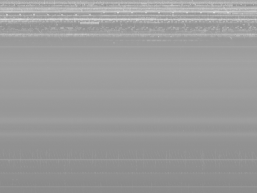

In [ ]:
IDX = 815
dd['test'][IDX]['image']

In [ ]:
dd['test'][IDX]['label']

0

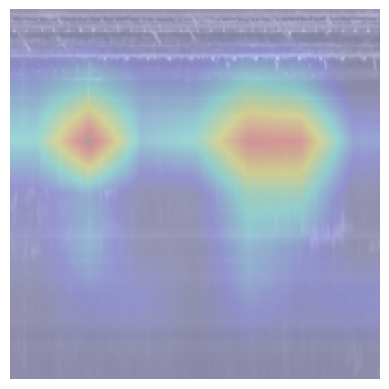

In [ ]:
# Correctly resize image to 224x224
resized_image = np.array(dd['test'][IDX]['image'].convert('RGB').resize((224, 224), Image.BILINEAR)) / 255

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=ds_test[IDX][0].unsqueeze(0), targets=targets)[0, :]

# Assuming grayscale_cam is correctly sized (224x224) but needs to be expanded for RGB overlay
# Normalize grayscale_cam for better visualization
grayscale_cam_normalized = grayscale_cam - np.min(grayscale_cam)
grayscale_cam_normalized = grayscale_cam_normalized / np.max(grayscale_cam_normalized)

# Expand grayscale_cam to have 3 channels
grayscale_cam_expanded = np.repeat(grayscale_cam_normalized[:, :, np.newaxis], 3, axis=2)

# Overlay grayscale_cam on resized_image
visualization = show_cam_on_image(resized_image, grayscale_cam_expanded, use_rgb=True, image_weight=0.8)

import matplotlib.pyplot as plt

# Assuming 'visualization' is your final overlay image
plt.imshow(visualization)
plt.axis('off')  # Remove axis ticks and labels
plt.show()

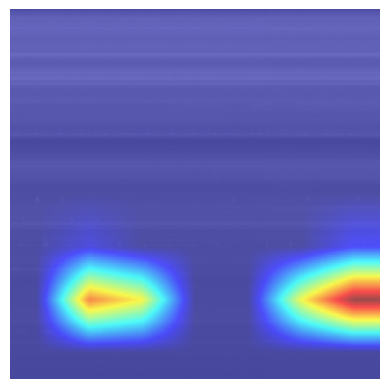

In [ ]:
IDX = 807
dd['test'][IDX]['image']
# Correctly resize image to 224x224
resized_image = np.array(dd['test'][IDX]['image'].convert('RGB').resize((224, 224), Image.BILINEAR)) / 255

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=ds_test[IDX][0].unsqueeze(0), targets=targets)[0, :]

# Assuming grayscale_cam is correctly sized (224x224) but needs to be expanded for RGB overlay
# Normalize grayscale_cam for better visualization
grayscale_cam_normalized = grayscale_cam - np.min(grayscale_cam)
grayscale_cam_normalized = grayscale_cam_normalized / np.max(grayscale_cam_normalized)

# Expand grayscale_cam to have 3 channels
grayscale_cam_expanded = np.repeat(grayscale_cam_normalized[:, :, np.newaxis], 3, axis=2)

# Overlay grayscale_cam on resized_image
visualization = show_cam_on_image(resized_image, grayscale_cam_expanded, use_rgb=True)

import matplotlib.pyplot as plt

# Assuming 'visualization' is your final overlay image
plt.imshow(visualization)
plt.axis('off')  # Remove axis ticks and labels
plt.show()